<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
import re
import spacy
from tqdm import notebook
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords as nltk_stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,make_scorer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import torch
import transformers
from tqdm import notebook
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

Установим spacy

In [2]:
import sys
!{sys.executable} -m pip install spacy;
!{sys.executable} -m spacy download en_core_web_sm;

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
df=pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.to_csv('toxic_comments.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


посмотрим на распределение целевого признака

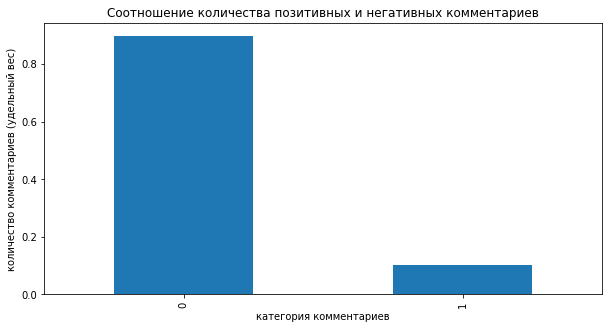

In [7]:
f, ax = plt.subplots(nrows=1, figsize=(10, 5))
df['toxic'].value_counts(normalize=True).plot.bar()
ax.set(title='Соотношение количества позитивных и негативных комментариев', xlabel= 'категория комментариев', ylabel = 'количество комментариев (удельный вес)');

мы наблюдаем существенный дисбаланс классов, поэтому применим функцию upsample для создания сбалансированности выборки 


In [8]:
def upsample(features, target, repeat): 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]  
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

также сздадим функцию для лемматизации и очистки комментариев

In [9]:
def lemma_by_spacy_clear(text):
    doc = nlp(text)
    doc=" ".join([token.lemma_ for token in doc])
    doc=re.sub(r'[^a-zA-Z ]',' ',doc)
  
    return " ".join(doc.split())

объявим модель spacy

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Разделим признаки на обучаюищий и целевой

In [11]:
features=df['text']
target=df['toxic']

Чистим и лемматизируем обучающую выборку

In [12]:
corpus_lemma=features.apply(lemma_by_spacy_clear)

Разделяем выборку на обучающую и тестовую

In [13]:
features_train,features_test,target_train,target_test=train_test_split(corpus_lemma,target,test_size=0.3,random_state=12345)

Применим функцию upsample

In [14]:
features_up,target_up=upsample(features_train,target_train,repeat=6)

посмотрим на баланс классов в случае применения техники upsampling и без ее применения

[Text(0, 0.5, 'количество'),
 Text(0.5, 0, 'категория комментариев'),
 Text(0.5, 1.0, 'Распределение биноминальных значений без балансировки')]

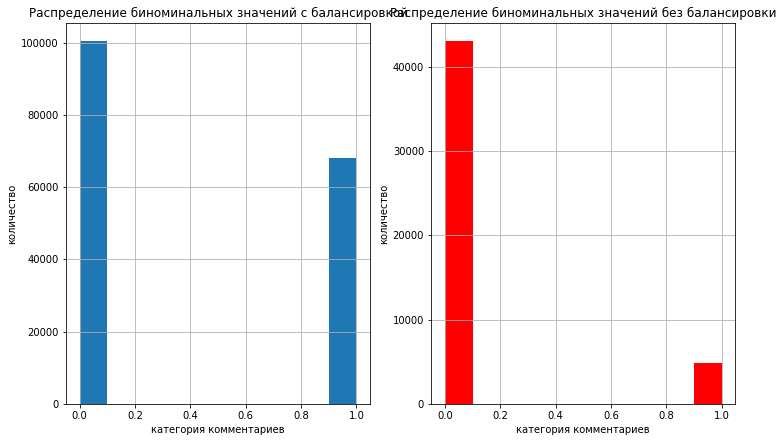

In [15]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
target_up.hist(ax=ax[0])
target_test.hist(ax = ax[1], color = 'r')
ax[0].set(title='Распределение биноминальных значений с балансировкой', xlabel='категория комментариев', ylabel = 'количество')
ax[1].set(title='Распределение биноминальных значений без балансировки', xlabel='категория комментариев', ylabel = 'количество')


как видим, в случае применения балансировки дисбаланс классов уменьшается

загружаем стоп слова

In [16]:
nltk.download('stopwords')# загружаю стоп слова
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


создадим счётчик, указав в нём стоп-слова

In [17]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

Переведем в векторный вид обучающую и тестовую выборки, считаем для них TF-IDF

In [18]:
corpus_tfid_train=count_tf_idf.fit_transform(features_up)
corpus_tfid_test=count_tf_idf.transform(features_test)

## Обучение

**model LogisticRegression**

In [19]:
features_train=corpus_tfid_train
target_train=target_up

In [20]:
features_test=corpus_tfid_test
target_test=target_test

для автоподбора гиперпараметров используем интрумент GridSearchCV 

In [21]:
model_log=LogisticRegression(n_jobs=-1, random_state=7).fit(features_train,target_train)

print("f1 для теста до подбора гиперпараметров:",f1_score(model_log.predict(features_test),target_test))

param_grid= [
    {'C': [2,4,5,6],
     'n_jobs': [-1,1]},
    {'C': np.logspace(-5, 0, 8)}
]
grid_model_log = GridSearchCV(model_log, param_grid, cv=3, n_jobs=-1,scoring='f1')

grid_model_log.fit(features_train, target_train)

# Печать настроенных параметров и оценка

print("Tuned Logistic Regression Parameters: {}".format(grid_model_log.best_params_)) 

print("Best F1 score is {}".format(grid_model_log.best_score_))

f1 для теста до подбора гиперпараметров: 0.7690382208529893
Tuned Logistic Regression Parameters: {'C': 6, 'n_jobs': -1}
Best F1 score is 0.9654266554869753


In [22]:
model_log_grid=LogisticRegression(n_jobs=-1,C=6, class_weight='balanced',random_state=7).fit(features_train,target_train)

In [23]:
f1_lr=f1_score(model_log_grid.predict(features_test),target_test)

In [24]:
print("f1:",round(f1_lr,2))

f1: 0.76


**model DecisionTreeClassifier**

In [25]:

model_tree=DecisionTreeClassifier(max_depth=2,random_state=42).fit(features_train,target_train)

print("f1 для теста до подбора гиперпараметров:",f1_score(model_tree.predict(features_test),target_test))

      
param_grid={"max_depth": [2,4,6,8,10],'class_weight':['balanced']}
    

grid_param_model_tree=GridSearchCV(model_tree,param_grid,cv=3,n_jobs=-1,scoring='f1') 

grid_param_model_tree.fit(features_train, target_train)

# Печать настроенных параметров и оценка

print("Tuned model DecisionTreeClassifier Parameters: {}".format(grid_param_model_tree.best_params_)) 

print("Best f1 score is {}".format(grid_param_model_tree.best_score_))

f1 для теста до подбора гиперпараметров: 0.311424638678596
Tuned model DecisionTreeClassifier Parameters: {'class_weight': 'balanced', 'max_depth': 2}
Best f1 score is 0.6144907050398701


In [26]:
model_tree_grid=DecisionTreeClassifier(max_depth=2,class_weight='balanced', random_state=42).fit(features_train,target_train)

In [27]:
f1_tree=f1_score(model_tree_grid.predict(features_test),target_test)

In [28]:
print("f1:",round(f1_tree,2 ))

f1: 0.22


**model CatBoostClassifier**

In [29]:
model_cat=CatBoostClassifier(loss_function="Logloss", iterations=50)

In [30]:
model_cat.fit(corpus_tfid_train,target_up)

Learning rate set to 0.5
0:	learn: 0.5443798	total: 9.28s	remaining: 7m 34s
1:	learn: 0.4875257	total: 14.4s	remaining: 5m 45s
2:	learn: 0.4582266	total: 19.3s	remaining: 5m 2s
3:	learn: 0.4353446	total: 24s	remaining: 4m 35s
4:	learn: 0.4190019	total: 29s	remaining: 4m 20s
5:	learn: 0.4060779	total: 33.8s	remaining: 4m 7s
6:	learn: 0.3945442	total: 38.5s	remaining: 3m 56s
7:	learn: 0.3853403	total: 43.3s	remaining: 3m 47s
8:	learn: 0.3751303	total: 48.1s	remaining: 3m 39s
9:	learn: 0.3683356	total: 52.9s	remaining: 3m 31s
10:	learn: 0.3617761	total: 57.5s	remaining: 3m 23s
11:	learn: 0.3549033	total: 1m 2s	remaining: 3m 16s
12:	learn: 0.3499211	total: 1m 6s	remaining: 3m 10s
13:	learn: 0.3462866	total: 1m 11s	remaining: 3m 3s
14:	learn: 0.3409668	total: 1m 16s	remaining: 2m 57s
15:	learn: 0.3367989	total: 1m 20s	remaining: 2m 51s
16:	learn: 0.3331335	total: 1m 25s	remaining: 2m 45s
17:	learn: 0.3291752	total: 1m 29s	remaining: 2m 39s
18:	learn: 0.3251530	total: 1m 34s	remaining: 2m 34

In [31]:
predict_cat=model_cat.predict(corpus_tfid_test)

In [32]:
confusion_matrix(predict_cat,target_test)

array([[41547,  1128],
       [ 1448,  3749]])

In [33]:
f1_cat=round(f1_score(predict_cat,target_test),2)
f1_cat

0.74

# Вывод

In [34]:
result=np.array([f1_lr,f1_tree,f1_cat])

In [35]:
result_df=pd.DataFrame(result,index=['LogisticRegression',"DecisionTreeClassifier", 'CatBoostClassifier'])
result_df.set_axis(['F1'],axis='columns',inplace=True)
result_df

,F1
LogisticRegression,0.761361
DecisionTreeClassifier,0.216742
CatBoostClassifier,0.740000


Как видим, лучший результат мы получили при использовании модели LogisticRegression со значением F1-меры на тестовой выборке равной 0,76, хуже всего себя показало дерево, при этом как при использовании логистической регрессии, так и дерева, мы наблюдаем переобучение.